# Create a Siamese Network with Triplet Loss in Keras

A Siamese neural network is an artificial neural network that uses the same weights while working in tandem on two different input vectors to compute comparable output vectors.

In this project, we'll create a siamese network, implement a triplet loss function, and train the network with the custom triplet loss function on the popular MNIST dataset. With this training process, the network will learn to produce feature embeddings of different classes from the dataset in a way that embeddings of examples from different classes will start to move away from each other in the vector space. This is the same idea that's used in a lot of face verification systems. The model is trianed to produce embeddings for faces in a way that embeddings of two images of the same person going to be a lot closer in the vector space compared to the embeddings of two images of two different people.

# Task 1: Understanding the Approach

In [1]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.0


## Understanding the Approach

This appraoch is taken from the popular [FaceNet](https://arxiv.org/abs/1503.03832) paper.

We have a CNN model called `EmbeddingModel`:

![CNN](assets/CNN.png)

The output has the same dimension as the output of the final dense layer i.e f(x) is an n-dim vector where n is the number of nodes in the final dense layer.
Instead of trying to get a probability score for all the classes that we'd normally do in a classification approach, we'll simply get a vector representation of an input image and that is called an embedding. The output f(x) for the image x is an embedding of the input image.

We use three images for each training example:
1. `person1_image1.jpg` (Anchor Example, represented below in green)
2. `person1_image2.jpg` (Positive Example, in blue)
3. `person2_image1.jpg` (Negative Example, in red).

![Embeddings](assets/embeddings.png)


## Siamese Network

All the three images of an example pass through the model, and we get the three Embeddings: One for the Anchor Example, one for the Positive Example, and one for the Negative Example.

![Siamese Network](assets/siamese.png)

The three instances of the `EmbeddingModel` shown above are not different instances. It's the same, shared model instance - i.e. the parameters are shared, and are updated for all the three paths simultaneously.

# Task 2: Importing the Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [3]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255. #Normalization - unrolling the examples from 28 by 28 arrays to 784 dimensional vectors
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


# Task 3: Plotting Examples

In [4]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary') #since they are greyscale images, hence binary.
        plt.xticks([])
        plt.yticks([])
    plt.show()

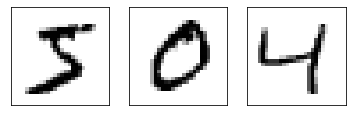

In [5]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

# Task 4: A Batch of Triplets

In [6]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784)) #because each example is essentially a list of 784 numbers
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y)) #To avoid extra dimension
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

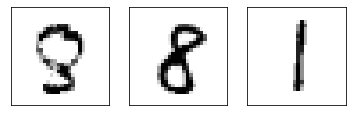

In [7]:
examples = create_batch(1)
plot_triplets(examples)

# Task 5: Embedding Model

In [8]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [9]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[0.5498627  0.47336215 0.5369103  0.51689637 0.49910238 0.5016883
 0.46502146 0.54978275 0.45726877 0.3716377  0.55345094 0.5546272
 0.43207157 0.4752819  0.52043885 0.3862764  0.43880692 0.33540964
 0.5522265  0.495404   0.48088244 0.4756963  0.47109514 0.52690554
 0.56537455 0.5305109  0.52569556 0.5069419  0.6714142  0.5681559
 0.52875733 0.53313833 0.64558506 0.47286582 0.50795925 0.4549983
 0.6127119  0.4555189  0.62690794 0.3880307  0.31839556 0.57007927
 0.53316003 0.5029943  0.4619262  0.54868877 0.31983387 0.5167423
 0.44730356 0.44422862 0.4973354  0.43776983 0.5772046  0.6254152
 0.53490126 0.46353507 0.39280018 0.5114401  0.47862434 0.44836396
 0.56102455 0.6596407  0.42655402 0.44942752]


# Task 6: Siamese Network

In [10]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]         

# Task 7: Triplet Loss

In order to train the siamese network that we just created and by extension essentially the embedding model, we will send batches of triplets to the model, get their embedding outputs and try to write a loss function that tries to pull the anchor and positive example closer and tries to push the embeddings of anchor and negative examples far apart.

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want the difference in the anchor in the positive distance should be less than the difference between the anchor in the negative distance:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training. It'd stop pushing $ \begin{equation} d_p, d_n \end{equation} $ further away from each other very soon during the training process.

So, We will make it a bit of non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [11]:
alpha = 0.2 #same value as used in phasenet paper

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

# Task 8: Data Generator

In [12]:
def data_generator(batch_size=256): #supplies a continuous stream of triplet examples to our model as it trains
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

# Task 9: Model Training

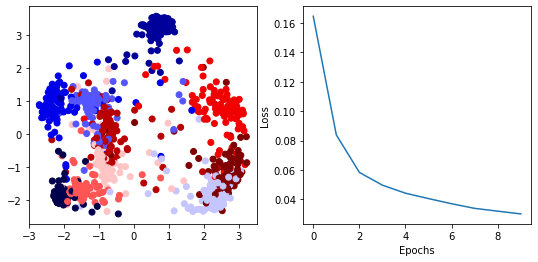

In [13]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=False,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:1000], y_test[:1000]
        )]
)